In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [89]:
device

device(type='cuda')

## Из уроков

In [62]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = None
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)

        if self.fc1 is None:
            in_features = x.size(1)
            self.fc1 = nn.Linear(in_features, 128).to(x.device)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)



class CNNWithResidual(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, 2)
        self.res3 = ResidualBlock(64, 64)

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc = nn.Linear(64 * 4 * 4, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class CIFARCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [90]:
def run_epoch(model, data_loader, criterion, optimizer=None, device='cpu', is_test=False):
    if is_test:
        model.eval()
    else:
        model.train()

    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
        data, target = data.to(device), target.to(device)

        if not is_test and optimizer is not None:
            optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        if not is_test and optimizer is not None:
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

    return total_loss / len(data_loader), correct / total


def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = run_epoch(model, train_loader, criterion, optimizer, device, is_test=False)
        test_loss, test_acc = run_epoch(model, test_loader, criterion, None, device, is_test=True)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
        print('-' * 50)

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

# Задание 1: Сравнение CNN и полносвязных сетей (40 баллов)

## 1.1 Сравнение на MNIST (20 баллов)

In [36]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset_mnist = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset_mnist = datasets.MNIST('./data', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_dataset_mnist, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(test_dataset_mnist, batch_size=64, shuffle=False)

Создал модели

In [38]:
class FCN(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.net(x)

class CNNWithResidualAndReg(nn.Module):
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout2d(0.3)
        self.res1 = ResidualBlock(32, 32)
        self.res2 = ResidualBlock(32, 64, stride=2)
        self.res3 = ResidualBlock(64, 64)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64*4*4, num_classes)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [28]:
epochs = 15
lr = 0.001

## Сравните производительность на MNIST:
## - Полносвязная сеть (3-4 слоя)
## - Простая CNN (2-3 conv слоя)
## - CNN с Residual Block

Полсносвязная сеть

In [37]:
model_fcn = FCN(28*28).to(device)
start = time.time()
results_fcn = train_model(model_fcn, train_loader_mnist, test_loader_mnist, epochs, lr, device)
fcn_time = time.time() - start

100%|██████████| 157/157 [00:01<00:00, 144.30it/s]


Epoch 1/15:
Train Loss: 0.2194, Train Acc: 0.9329
Test Loss: 0.0940, Test Acc: 0.9709
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 151.72it/s]


Epoch 2/15:
Train Loss: 0.0883, Train Acc: 0.9729
Test Loss: 0.0778, Test Acc: 0.9762
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 141.67it/s]


Epoch 3/15:
Train Loss: 0.0626, Train Acc: 0.9812
Test Loss: 0.0726, Test Acc: 0.9792
--------------------------------------------------


100%|██████████| 157/157 [00:00<00:00, 158.51it/s]


Epoch 4/15:
Train Loss: 0.0458, Train Acc: 0.9859
Test Loss: 0.1079, Test Acc: 0.9709
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 156.02it/s]


Epoch 5/15:
Train Loss: 0.0395, Train Acc: 0.9873
Test Loss: 0.0676, Test Acc: 0.9805
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 107.95it/s]


Epoch 6/15:
Train Loss: 0.0293, Train Acc: 0.9910
Test Loss: 0.0841, Test Acc: 0.9784
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 147.26it/s]


Epoch 7/15:
Train Loss: 0.0266, Train Acc: 0.9919
Test Loss: 0.0870, Test Acc: 0.9802
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 155.24it/s]


Epoch 8/15:
Train Loss: 0.0240, Train Acc: 0.9927
Test Loss: 0.0872, Test Acc: 0.9800
--------------------------------------------------


100%|██████████| 157/157 [00:00<00:00, 160.71it/s]


Epoch 9/15:
Train Loss: 0.0209, Train Acc: 0.9935
Test Loss: 0.0953, Test Acc: 0.9796
--------------------------------------------------


100%|██████████| 157/157 [00:00<00:00, 160.71it/s]


Epoch 10/15:
Train Loss: 0.0172, Train Acc: 0.9946
Test Loss: 0.0836, Test Acc: 0.9831
--------------------------------------------------


100%|██████████| 157/157 [00:00<00:00, 160.69it/s]


Epoch 11/15:
Train Loss: 0.0190, Train Acc: 0.9942
Test Loss: 0.0849, Test Acc: 0.9814
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 136.58it/s]


Epoch 12/15:
Train Loss: 0.0131, Train Acc: 0.9958
Test Loss: 0.0942, Test Acc: 0.9804
--------------------------------------------------


100%|██████████| 157/157 [00:00<00:00, 159.06it/s]


Epoch 13/15:
Train Loss: 0.0159, Train Acc: 0.9954
Test Loss: 0.1087, Test Acc: 0.9785
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 128.73it/s]


Epoch 14/15:
Train Loss: 0.0160, Train Acc: 0.9950
Test Loss: 0.0917, Test Acc: 0.9810
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 125.05it/s]

Epoch 15/15:
Train Loss: 0.0114, Train Acc: 0.9966
Test Loss: 0.0888, Test Acc: 0.9827
--------------------------------------------------


Простая cnn

In [39]:
model_cnn = SimpleCNN(input_channels=1).to(device)
start = time.time()
results_cnn = train_model(model_cnn, train_loader_mnist, test_loader_mnist, epochs, lr, device)
cnn_time = time.time() - start

100%|██████████| 157/157 [00:01<00:00, 151.00it/s]


Epoch 1/15:
Train Loss: 0.2035, Train Acc: 0.9374
Test Loss: 0.0516, Test Acc: 0.9843
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 150.06it/s]


Epoch 2/15:
Train Loss: 0.0643, Train Acc: 0.9808
Test Loss: 0.0328, Test Acc: 0.9887
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 117.05it/s]


Epoch 3/15:
Train Loss: 0.0457, Train Acc: 0.9859
Test Loss: 0.0296, Test Acc: 0.9904
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 151.71it/s]


Epoch 4/15:
Train Loss: 0.0363, Train Acc: 0.9889
Test Loss: 0.0271, Test Acc: 0.9914
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 146.01it/s]


Epoch 5/15:
Train Loss: 0.0290, Train Acc: 0.9909
Test Loss: 0.0266, Test Acc: 0.9903
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 139.98it/s]


Epoch 6/15:
Train Loss: 0.0246, Train Acc: 0.9917
Test Loss: 0.0288, Test Acc: 0.9904
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 150.31it/s]


Epoch 7/15:
Train Loss: 0.0212, Train Acc: 0.9933
Test Loss: 0.0292, Test Acc: 0.9909
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 122.30it/s]


Epoch 8/15:
Train Loss: 0.0196, Train Acc: 0.9937
Test Loss: 0.0263, Test Acc: 0.9912
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 142.12it/s]


Epoch 9/15:
Train Loss: 0.0161, Train Acc: 0.9944
Test Loss: 0.0265, Test Acc: 0.9915
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 151.45it/s]


Epoch 10/15:
Train Loss: 0.0134, Train Acc: 0.9953
Test Loss: 0.0267, Test Acc: 0.9919
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 151.04it/s]


Epoch 11/15:
Train Loss: 0.0118, Train Acc: 0.9963
Test Loss: 0.0263, Test Acc: 0.9920
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 150.57it/s]


Epoch 12/15:
Train Loss: 0.0111, Train Acc: 0.9961
Test Loss: 0.0301, Test Acc: 0.9924
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 63.49it/s]


Epoch 13/15:
Train Loss: 0.0099, Train Acc: 0.9965
Test Loss: 0.0277, Test Acc: 0.9925
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 110.63it/s]


Epoch 14/15:
Train Loss: 0.0086, Train Acc: 0.9971
Test Loss: 0.0249, Test Acc: 0.9938
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 135.73it/s]

Epoch 15/15:
Train Loss: 0.0083, Train Acc: 0.9972
Test Loss: 0.0271, Test Acc: 0.9924
--------------------------------------------------


In [40]:
model_resnet = CNNWithResidual(input_channels=1).to(device)
start = time.time()
results_resnet = train_model(model_resnet, train_loader_mnist, test_loader_mnist, epochs, lr, device)
resnet_time = time.time() - start

100%|██████████| 157/157 [00:01<00:00, 122.52it/s]


Epoch 1/15:
Train Loss: 0.1041, Train Acc: 0.9699
Test Loss: 0.0548, Test Acc: 0.9820
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 105.39it/s]


Epoch 2/15:
Train Loss: 0.0400, Train Acc: 0.9874
Test Loss: 0.0363, Test Acc: 0.9880
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 120.21it/s]


Epoch 3/15:
Train Loss: 0.0312, Train Acc: 0.9901
Test Loss: 0.0306, Test Acc: 0.9891
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 121.56it/s]


Epoch 4/15:
Train Loss: 0.0273, Train Acc: 0.9914
Test Loss: 0.0296, Test Acc: 0.9906
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 120.99it/s]


Epoch 5/15:
Train Loss: 0.0220, Train Acc: 0.9930
Test Loss: 0.0208, Test Acc: 0.9935
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 104.33it/s]


Epoch 6/15:
Train Loss: 0.0197, Train Acc: 0.9937
Test Loss: 0.0277, Test Acc: 0.9923
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 117.68it/s]


Epoch 7/15:
Train Loss: 0.0161, Train Acc: 0.9947
Test Loss: 0.0183, Test Acc: 0.9938
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 120.87it/s]


Epoch 8/15:
Train Loss: 0.0161, Train Acc: 0.9949
Test Loss: 0.0212, Test Acc: 0.9933
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 118.77it/s]


Epoch 9/15:
Train Loss: 0.0128, Train Acc: 0.9959
Test Loss: 0.0162, Test Acc: 0.9949
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 91.33it/s] 


Epoch 10/15:
Train Loss: 0.0126, Train Acc: 0.9957
Test Loss: 0.0169, Test Acc: 0.9958
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 123.33it/s]


Epoch 11/15:
Train Loss: 0.0108, Train Acc: 0.9967
Test Loss: 0.0207, Test Acc: 0.9939
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 122.07it/s]


Epoch 12/15:
Train Loss: 0.0092, Train Acc: 0.9970
Test Loss: 0.0148, Test Acc: 0.9946
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 97.70it/s]


Epoch 13/15:
Train Loss: 0.0082, Train Acc: 0.9973
Test Loss: 0.0196, Test Acc: 0.9938
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 122.73it/s]


Epoch 14/15:
Train Loss: 0.0082, Train Acc: 0.9972
Test Loss: 0.0190, Test Acc: 0.9948
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 123.69it/s]

Epoch 15/15:
Train Loss: 0.0058, Train Acc: 0.9982
Test Loss: 0.0190, Test Acc: 0.9951
--------------------------------------------------


Сравнение результатов

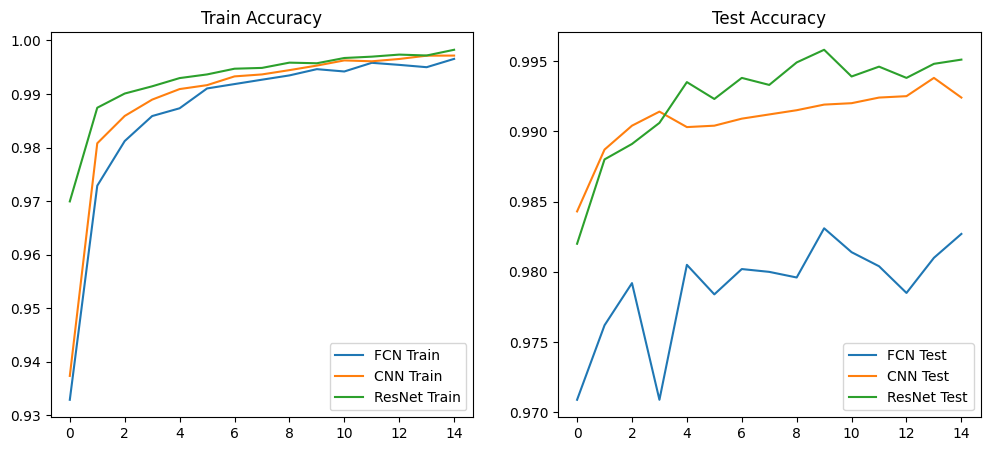

In [41]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(results_fcn['train_accs'], label="FCN Train")
plt.plot(results_cnn['train_accs'], label="CNN Train")
plt.plot(results_resnet['train_accs'], label="ResNet Train")
plt.title("Train Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(results_fcn['test_accs'], label="FCN Test")
plt.plot(results_cnn['test_accs'], label="CNN Test")
plt.plot(results_resnet['test_accs'], label="ResNet Test")
plt.title("Test Accuracy")
plt.legend()

plt.show()

In [42]:
print("FCN params:", sum(p.numel() for p in model_fcn.parameters()))
print("Simple CNN params:", sum(p.numel() for p in model_cnn.parameters()))
print("ResNet CNN params:", sum(p.numel() for p in model_resnet.parameters()))

print(f"FCN time: {fcn_time:.2f}s")
print(f"Simple CNN time: {cnn_time:.2f}s")
print(f"ResNet CNN time: {resnet_time:.2f}s")

FCN params: 1462538
Simple CNN params: 421642
ResNet CNN params: 160906
FCN time: 144.19s
Simple CNN time: 168.00s
ResNet CNN time: 232.06s


## 1.2 Сравнение на CIFAR-10 (20 баллов)

In [ ]:
# Сравните производительность на CIFAR-10:
# - Полносвязная сеть (глубокая)
# - CNN с Residual блоками
# - CNN с регуляризацией и Residual блоками
#
# Для каждого варианта:
# - Обучите модель с одинаковыми гиперпараметрами
# - Сравните точность и время обучения
# - Проанализируйте переобучение
# - Визуализируйте confusion matrix
# - Исследуйте градиенты (gradient flow)

In [43]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset_cifar = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
test_dataset_cifar = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

train_loader_cifar = DataLoader(train_dataset_cifar, batch_size=64, shuffle=True)
test_loader_cifar = DataLoader(test_dataset_cifar, batch_size=64, shuffle=False)

In [112]:
import numpy as np

def train_model_with_grads(model, train_loader, test_loader, epochs=15, lr=0.001):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    grad_norms = []

    for epoch in range(epochs):
        model.train()
        epoch_loss, correct, total = 0,0,0
        epoch_grads = []

        for data, target in tqdm(train_loader, leave=False):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.detach().data.norm(2)
                    total_norm += param_norm.item() **2
            total_norm = total_norm **0.5
            epoch_grads.append(total_norm)

            optimizer.step()
            epoch_loss += loss.item()
            preds = output.argmax(dim=1)
            correct += preds.eq(target).sum().item()
            total += target.size(0)

        train_losses.append(epoch_loss/len(train_loader))
        train_accs.append(correct/total)
        grad_norms.append(np.mean(epoch_grads))

        model.eval()
        test_loss, correct, total =0,0,0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                test_loss += loss.item()
                preds = output.argmax(dim=1)
                correct += preds.eq(target).sum().item()
                total += target.size(0)

        test_losses.append(test_loss/len(test_loader))
        test_accs.append(correct/total)

        print(f"Epoch {epoch+1}: Train loss={train_losses[-1]:.4f}, Test Acc={test_accs[-1]:.4f}")

    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accs": train_accs,
        "test_accs": test_accs,
        "grad_norms": grad_norms
    }

Полносвязная сеть

In [54]:
model_fcn = FCN(32*32*3).to(device)
start = time.time()
results_fcn = train_model_with_grads(model_fcn, train_loader_cifar, test_loader_cifar, epochs, lr)
fcn_time = time.time() - start

Epoch 1: Train loss=1.8714, Test Acc=0.3753


Epoch 2: Train loss=1.6923, Test Acc=0.4075


Epoch 3: Train loss=1.6045, Test Acc=0.4361


Epoch 4: Train loss=1.5414, Test Acc=0.4541


Epoch 5: Train loss=1.4871, Test Acc=0.4360


Epoch 6: Train loss=1.4517, Test Acc=0.4852


Epoch 7: Train loss=1.4062, Test Acc=0.4759


Epoch 8: Train loss=1.3857, Test Acc=0.4790


Epoch 9: Train loss=1.3522, Test Acc=0.4923


Epoch 10: Train loss=1.3206, Test Acc=0.4988


Epoch 11: Train loss=1.2983, Test Acc=0.4962


Epoch 12: Train loss=1.2678, Test Acc=0.4972


Epoch 13: Train loss=1.2372, Test Acc=0.4999


Epoch 14: Train loss=1.2160, Test Acc=0.5071


Epoch 15: Train loss=1.1916, Test Acc=0.4994


In [63]:
model_cnn = SimpleCNN(input_channels=3).to(device)
start = time.time()
results_cnn = train_model_with_grads(model_cnn, train_loader_cifar, test_loader_cifar, epochs, lr)
cnn_time = time.time() - start

Epoch 1: Train loss=1.8805, Test Acc=0.4204


Epoch 2: Train loss=1.6019, Test Acc=0.4749


Epoch 3: Train loss=1.5109, Test Acc=0.4944


Epoch 4: Train loss=1.4697, Test Acc=0.5084


Epoch 5: Train loss=1.4343, Test Acc=0.5220


Epoch 6: Train loss=1.4076, Test Acc=0.5214


Epoch 7: Train loss=1.3877, Test Acc=0.5315


Epoch 8: Train loss=1.3657, Test Acc=0.5454


Epoch 9: Train loss=1.3477, Test Acc=0.5484


Epoch 10: Train loss=1.3303, Test Acc=0.5555


Epoch 11: Train loss=1.3144, Test Acc=0.5562


Epoch 12: Train loss=1.2964, Test Acc=0.5635


Epoch 13: Train loss=1.2828, Test Acc=0.5727


Epoch 14: Train loss=1.2718, Test Acc=0.5738


Epoch 15: Train loss=1.2614, Test Acc=0.5776


CNN с Residual блоками

In [64]:
model_resnet = CNNWithResidual(input_channels=3).to(device)
start = time.time()
results_resnet = train_model_with_grads(model_resnet, train_loader_cifar, test_loader_cifar, epochs, lr)
resnet_time = time.time() - start

Epoch 1: Train loss=1.1780, Test Acc=0.6468


Epoch 2: Train loss=0.7979, Test Acc=0.7238


Epoch 3: Train loss=0.6595, Test Acc=0.7637


Epoch 4: Train loss=0.5697, Test Acc=0.7681


Epoch 5: Train loss=0.5056, Test Acc=0.7913


Epoch 6: Train loss=0.4486, Test Acc=0.7946


Epoch 7: Train loss=0.4008, Test Acc=0.8079


Epoch 8: Train loss=0.3601, Test Acc=0.8122


Epoch 9: Train loss=0.3196, Test Acc=0.7988


Epoch 10: Train loss=0.2868, Test Acc=0.8145


Epoch 11: Train loss=0.2485, Test Acc=0.8148


Epoch 12: Train loss=0.2237, Test Acc=0.8041


Epoch 13: Train loss=0.1929, Test Acc=0.8215


Epoch 14: Train loss=0.1716, Test Acc=0.8116


Epoch 15: Train loss=0.1504, Test Acc=0.7976


CNN с Residual и регуляризацией

In [65]:
model_resreg = CNNWithResidualAndReg(input_channels=3).to(device)
start = time.time()
results_resreg = train_model_with_grads(model_resreg, train_loader_cifar, test_loader_cifar, epochs, lr)
resreg_time = time.time() - start

Epoch 1: Train loss=1.4147, Test Acc=0.6304


Epoch 2: Train loss=0.9795, Test Acc=0.7119


Epoch 3: Train loss=0.8381, Test Acc=0.7341


Epoch 4: Train loss=0.7495, Test Acc=0.7594


Epoch 5: Train loss=0.6824, Test Acc=0.7760


Epoch 6: Train loss=0.6319, Test Acc=0.7667


Epoch 7: Train loss=0.5876, Test Acc=0.7806


Epoch 8: Train loss=0.5550, Test Acc=0.8068


Epoch 9: Train loss=0.5212, Test Acc=0.8213


Epoch 10: Train loss=0.4890, Test Acc=0.8031


Epoch 11: Train loss=0.4643, Test Acc=0.8182


Epoch 12: Train loss=0.4379, Test Acc=0.8215


Epoch 13: Train loss=0.4200, Test Acc=0.8077


Epoch 14: Train loss=0.4008, Test Acc=0.8162


Epoch 15: Train loss=0.3769, Test Acc=0.8206


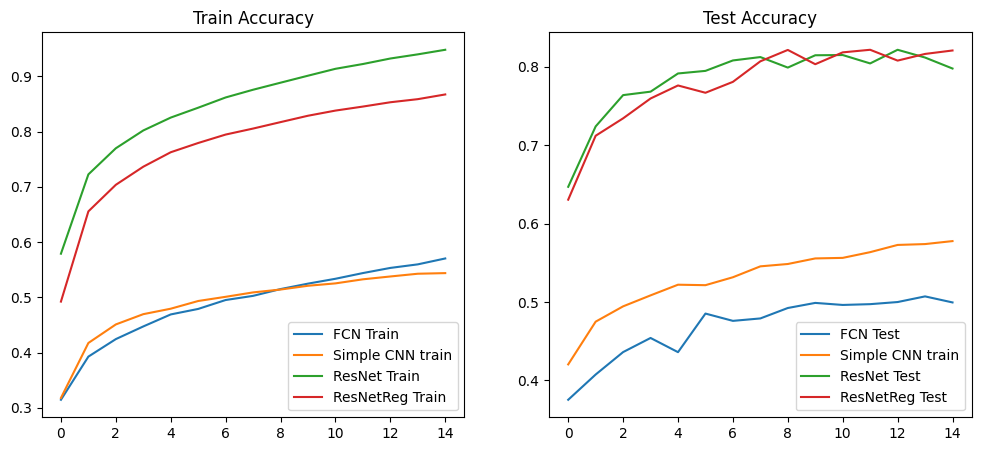

In [70]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(results_fcn['train_accs'], label='FCN Train')
plt.plot(results_cnn['train_accs'], label='Simple CNN train')
plt.plot(results_resnet['train_accs'], label='ResNet Train')
plt.plot(results_resreg['train_accs'], label='ResNetReg Train')
plt.title("Train Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(results_fcn['test_accs'], label='FCN Test')
plt.plot(results_cnn['test_accs'], label='Simple CNN train')
plt.plot(results_resnet['test_accs'], label='ResNet Test')
plt.plot(results_resreg['test_accs'], label='ResNetReg Test')
plt.title("Test Accuracy")
plt.legend()
plt.show()

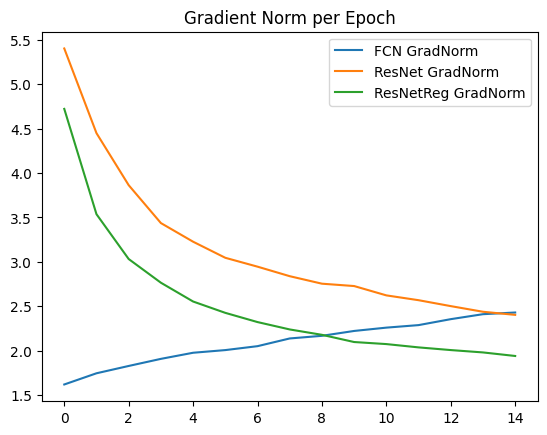

In [73]:
plt.figure()
plt.plot(results_fcn['grad_norms'], label='FCN GradNorm')
plt.plot(results_resnet['grad_norms'], label='ResNet GradNorm')
plt.plot(results_resreg['grad_norms'], label='ResNetReg GradNorm')
plt.title("Gradient Norm per Epoch")
plt.legend()
plt.show()

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader, class_names=None, is_fcn=False):
    model.eval()
    device = next(model.parameters()).device
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            if is_fcn:
                xb = xb.view(xb.size(0), -1)
            outputs = model(xb)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Confusion Matrix for FCN


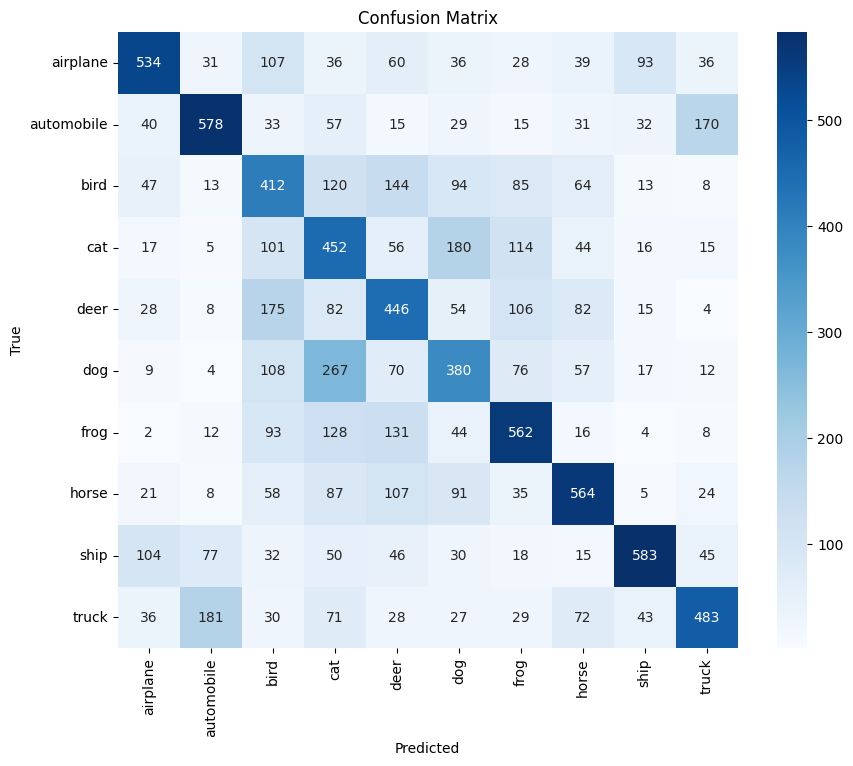

Confusion Matrix for Simple CNN


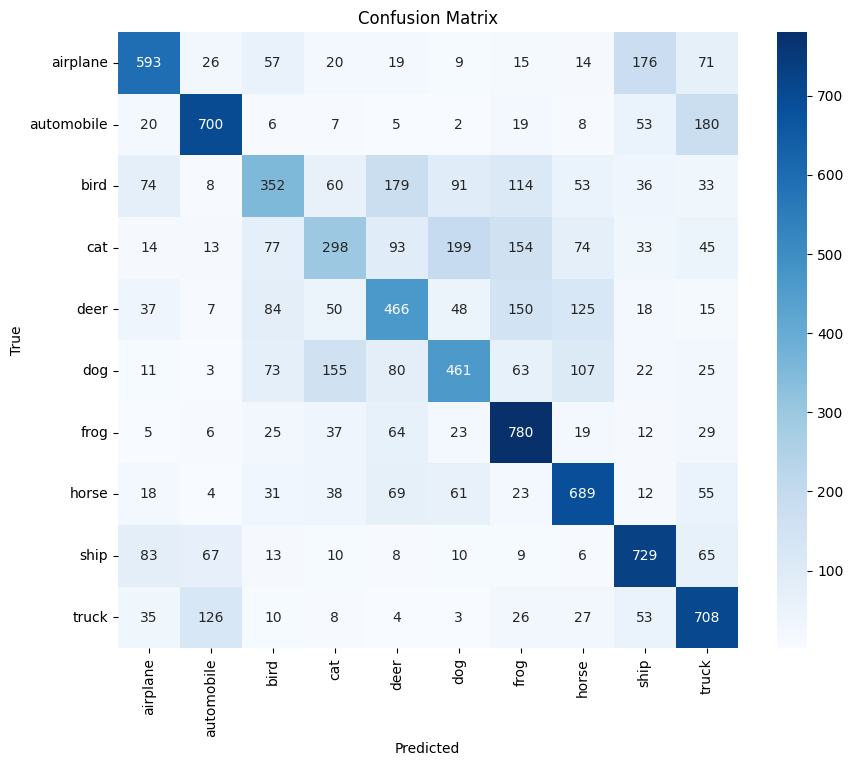

Confusion Matrix for ResNet


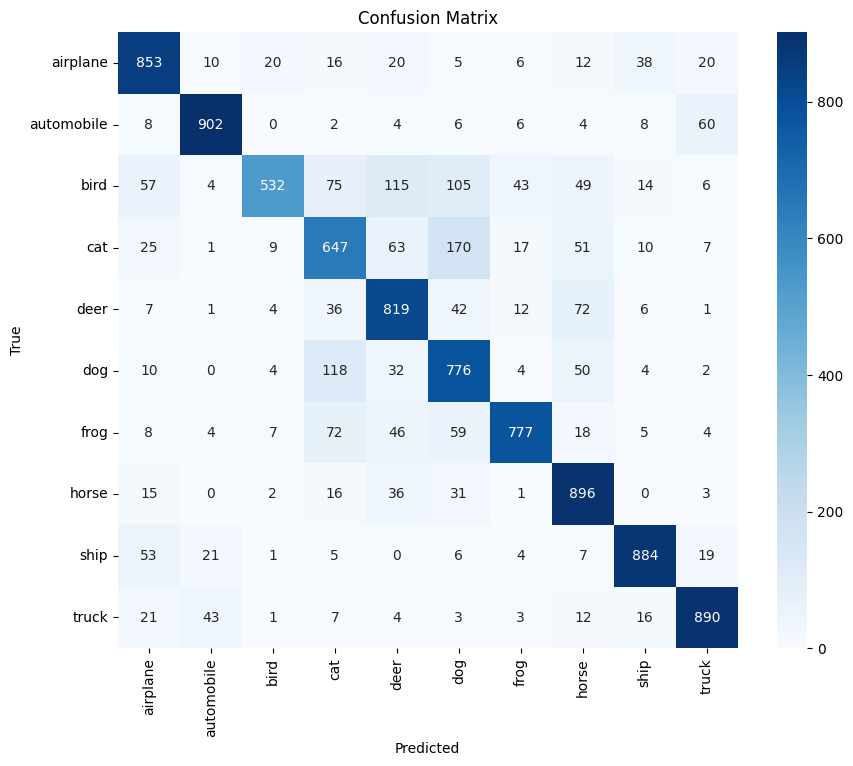

Confusion Matrix for ResNet with Regularization


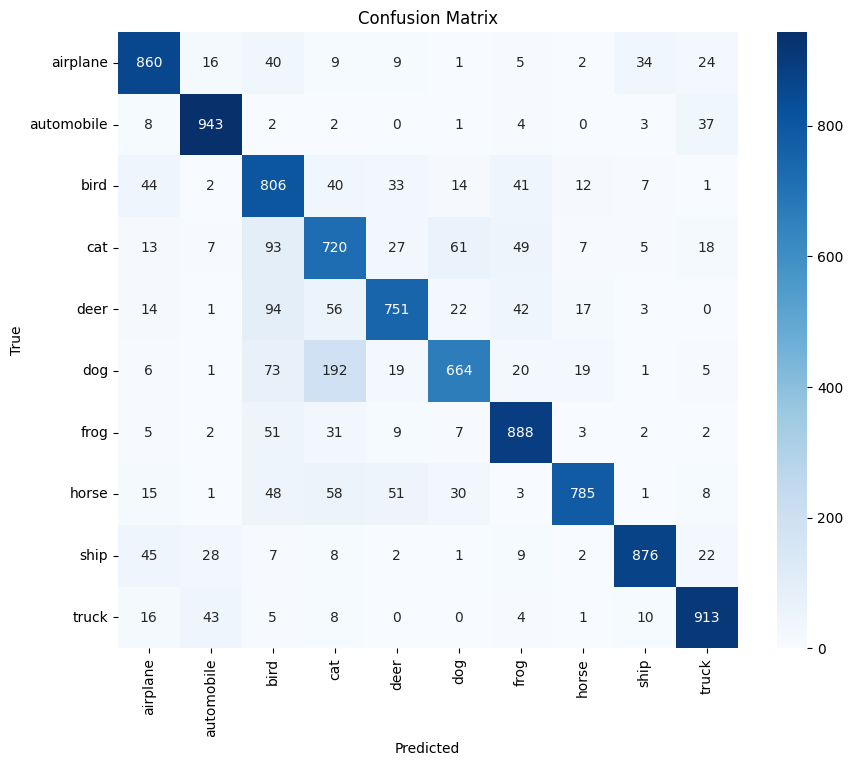

In [77]:
class_names_cifar = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
models_cifar = [
    model_fcn,
    model_cnn,
    model_resnet,
    model_resreg
]
names_cifar = [
    "FCN",
    "Simple CNN",
    "ResNet",
    "ResNet with Regularization"
]

for model, name in zip(models_cifar, names_cifar):
    print(f"Confusion Matrix for {name}")
    plot_confusion_matrix(
        model,
        test_loader_cifar,
        class_names=class_names_cifar,
        is_fcn=(name=="FCN")
    )


# Задание 2: Анализ архитектур CNN (30 баллов)

## 2.1 Влияние размера ядра свертки (15 баллов)

In [ ]:
# Исследуйте влияние размера ядра свертки:
# - 3x3 ядра
# - 5x5 ядра
# - 7x7 ядра
# - Комбинация разных размеров (1x1 + 3x3)
#
# Для каждого варианта:
# - Поддерживайте одинаковое количество параметров
# - Сравните точность и время обучения
# - Проанализируйте рецептивные поля
# - Визуализируйте активации первого слоя

In [78]:
class KernelSizeCNN(nn.Module):
    def __init__(self, kernel_size=3, out_channels=32):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(3, out_channels, kernel_size, padding=padding)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(out_channels, out_channels*2, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear((out_channels*2)*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ComboCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Conv2d(3, 32, 1)
        self.conv3x3 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1x1(x))
        x = self.pool(F.relu(self.conv3x3(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [92]:
def plot_confusion_matrix(model, test_loader, class_names=None, is_fcn=False, device='cpu'):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            if is_fcn:
                xb = xb.view(xb.size(0), -1)
            outputs = model(xb)
            preds = outputs.argmax(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(yb.cpu().numpy())

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


In [81]:
configs = [
    {"kernel_size":3, "out_channels":64},
    {"kernel_size":5, "out_channels":32},
    {"kernel_size":7, "out_channels":16}
]

results = []
epochs = 10

In [99]:
trained_models = []
for cfg in configs:
    label = f"{cfg['kernel_size']}x{cfg['kernel_size']}"
    print(f"Training {label}")
    model = KernelSizeCNN(kernel_size=cfg["kernel_size"], out_channels=cfg["out_channels"]).to(device)

    start = time.time()
    results = train_model(model, train_loader_cifar, test_loader_cifar, epochs, lr, device)
    t = time.time()-start

    trained_models.append({
        "label": label,
        "model": model,
        "results": results,
        "time": t
    })


Training 3x3


100%|██████████| 157/157 [00:01<00:00, 107.79it/s]


Epoch 1/10:
Train Loss: 1.4325, Train Acc: 0.4856
Test Loss: 1.1634, Test Acc: 0.5846
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 69.55it/s]


Epoch 2/10:
Train Loss: 1.0537, Train Acc: 0.6290
Test Loss: 1.0497, Test Acc: 0.6329
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 60.26it/s]


Epoch 3/10:
Train Loss: 0.8958, Train Acc: 0.6854
Test Loss: 0.9096, Test Acc: 0.6841
--------------------------------------------------


100%|██████████| 157/157 [00:03<00:00, 40.73it/s]


Epoch 4/10:
Train Loss: 0.7889, Train Acc: 0.7239
Test Loss: 0.8783, Test Acc: 0.6967
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 54.75it/s]


Epoch 5/10:
Train Loss: 0.7104, Train Acc: 0.7513
Test Loss: 0.8221, Test Acc: 0.7186
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 107.71it/s]


Epoch 6/10:
Train Loss: 0.6291, Train Acc: 0.7802
Test Loss: 0.8597, Test Acc: 0.7110
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 106.89it/s]


Epoch 7/10:
Train Loss: 0.5570, Train Acc: 0.8051
Test Loss: 0.8739, Test Acc: 0.7083
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 106.59it/s]


Epoch 8/10:
Train Loss: 0.4874, Train Acc: 0.8279
Test Loss: 0.8812, Test Acc: 0.7076
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 106.79it/s]


Epoch 9/10:
Train Loss: 0.4232, Train Acc: 0.8506
Test Loss: 0.9634, Test Acc: 0.7066
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 106.36it/s]


Epoch 10/10:
Train Loss: 0.3603, Train Acc: 0.8737
Test Loss: 1.0009, Test Acc: 0.7134
--------------------------------------------------
Training 5x5


100%|██████████| 157/157 [00:01<00:00, 114.34it/s]


Epoch 1/10:
Train Loss: 1.4500, Train Acc: 0.4791
Test Loss: 1.2198, Test Acc: 0.5663
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.01it/s]


Epoch 2/10:
Train Loss: 1.0988, Train Acc: 0.6099
Test Loss: 1.0413, Test Acc: 0.6291
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 89.14it/s] 


Epoch 3/10:
Train Loss: 0.9503, Train Acc: 0.6656
Test Loss: 1.0327, Test Acc: 0.6414
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 92.99it/s]


Epoch 4/10:
Train Loss: 0.8507, Train Acc: 0.7017
Test Loss: 0.9452, Test Acc: 0.6751
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 111.94it/s]


Epoch 5/10:
Train Loss: 0.7666, Train Acc: 0.7315
Test Loss: 0.8909, Test Acc: 0.6942
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 115.95it/s]


Epoch 6/10:
Train Loss: 0.6964, Train Acc: 0.7575
Test Loss: 0.8898, Test Acc: 0.6994
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.65it/s]


Epoch 7/10:
Train Loss: 0.6241, Train Acc: 0.7820
Test Loss: 0.9016, Test Acc: 0.7000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.66it/s]


Epoch 8/10:
Train Loss: 0.5608, Train Acc: 0.8030
Test Loss: 0.9007, Test Acc: 0.7076
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 111.71it/s]


Epoch 9/10:
Train Loss: 0.4959, Train Acc: 0.8255
Test Loss: 1.0356, Test Acc: 0.6860
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 109.54it/s]


Epoch 10/10:
Train Loss: 0.4377, Train Acc: 0.8446
Test Loss: 1.0307, Test Acc: 0.6918
--------------------------------------------------
Training 7x7


100%|██████████| 157/157 [00:01<00:00, 114.30it/s]


Epoch 1/10:
Train Loss: 1.6016, Train Acc: 0.4218
Test Loss: 1.3824, Test Acc: 0.5005
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.18it/s]


Epoch 2/10:
Train Loss: 1.2769, Train Acc: 0.5473
Test Loss: 1.2234, Test Acc: 0.5623
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 115.41it/s]


Epoch 3/10:
Train Loss: 1.1343, Train Acc: 0.5974
Test Loss: 1.1032, Test Acc: 0.6130
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 108.44it/s]


Epoch 4/10:
Train Loss: 1.0301, Train Acc: 0.6371
Test Loss: 1.0579, Test Acc: 0.6284
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 84.46it/s]


Epoch 5/10:
Train Loss: 0.9435, Train Acc: 0.6698
Test Loss: 1.0919, Test Acc: 0.6231
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 93.47it/s]


Epoch 6/10:
Train Loss: 0.8751, Train Acc: 0.6919
Test Loss: 0.9821, Test Acc: 0.6618
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.38it/s]


Epoch 7/10:
Train Loss: 0.8089, Train Acc: 0.7153
Test Loss: 1.0092, Test Acc: 0.6642
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.66it/s]


Epoch 8/10:
Train Loss: 0.7505, Train Acc: 0.7358
Test Loss: 0.9877, Test Acc: 0.6631
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.08it/s]


Epoch 9/10:
Train Loss: 0.6991, Train Acc: 0.7537
Test Loss: 0.9969, Test Acc: 0.6702
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.38it/s]

Epoch 10/10:
Train Loss: 0.6433, Train Acc: 0.7733
Test Loss: 1.0020, Test Acc: 0.6758
--------------------------------------------------


In [100]:
print("Training 1x1 + 3x3 Combo")
model_combo = ComboCNN().to(device)
start = time.time()
results_combo = train_model(model_combo, train_loader_cifar, test_loader_cifar, epochs, lr, device)
time_combo = time.time()-start

trained_models.append({
    "label": "1x1+3x3",
    "model": model_combo,
    "results": results_combo,
    "time": time_combo
})

Training 1x1 + 3x3 Combo


100%|██████████| 157/157 [00:01<00:00, 110.61it/s]


Epoch 1/10:
Train Loss: 1.5657, Train Acc: 0.4343
Test Loss: 1.2731, Test Acc: 0.5449
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.08it/s]


Epoch 2/10:
Train Loss: 1.2014, Train Acc: 0.5725
Test Loss: 1.0988, Test Acc: 0.6139
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.54it/s]


Epoch 3/10:
Train Loss: 1.0158, Train Acc: 0.6405
Test Loss: 1.0456, Test Acc: 0.6374
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.50it/s]


Epoch 4/10:
Train Loss: 0.8847, Train Acc: 0.6904
Test Loss: 0.9613, Test Acc: 0.6654
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.83it/s]


Epoch 5/10:
Train Loss: 0.7899, Train Acc: 0.7211
Test Loss: 0.9653, Test Acc: 0.6640
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.80it/s]


Epoch 6/10:
Train Loss: 0.7078, Train Acc: 0.7500
Test Loss: 0.9310, Test Acc: 0.6845
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.78it/s]


Epoch 7/10:
Train Loss: 0.6332, Train Acc: 0.7766
Test Loss: 0.9506, Test Acc: 0.6925
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.83it/s]


Epoch 8/10:
Train Loss: 0.5708, Train Acc: 0.7990
Test Loss: 0.9822, Test Acc: 0.6979
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.13it/s]


Epoch 9/10:
Train Loss: 0.5106, Train Acc: 0.8187
Test Loss: 1.0164, Test Acc: 0.6813
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 115.19it/s]

Epoch 10/10:
Train Loss: 0.4487, Train Acc: 0.8423
Test Loss: 1.0665, Test Acc: 0.6799
--------------------------------------------------


Confusion Matrix for 3x3


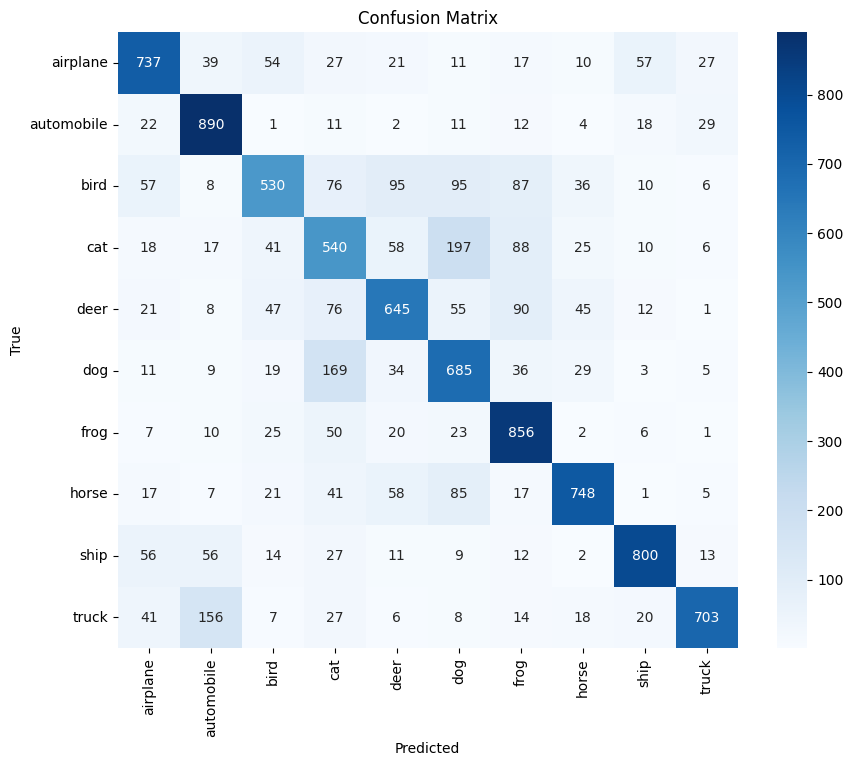

Confusion Matrix for 5x5


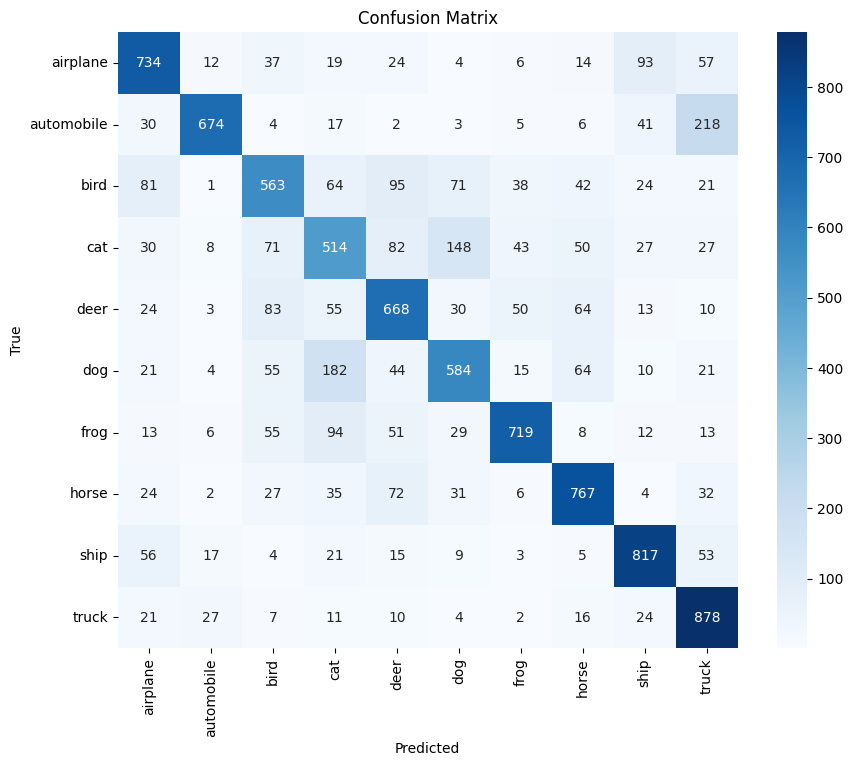

Confusion Matrix for 7x7


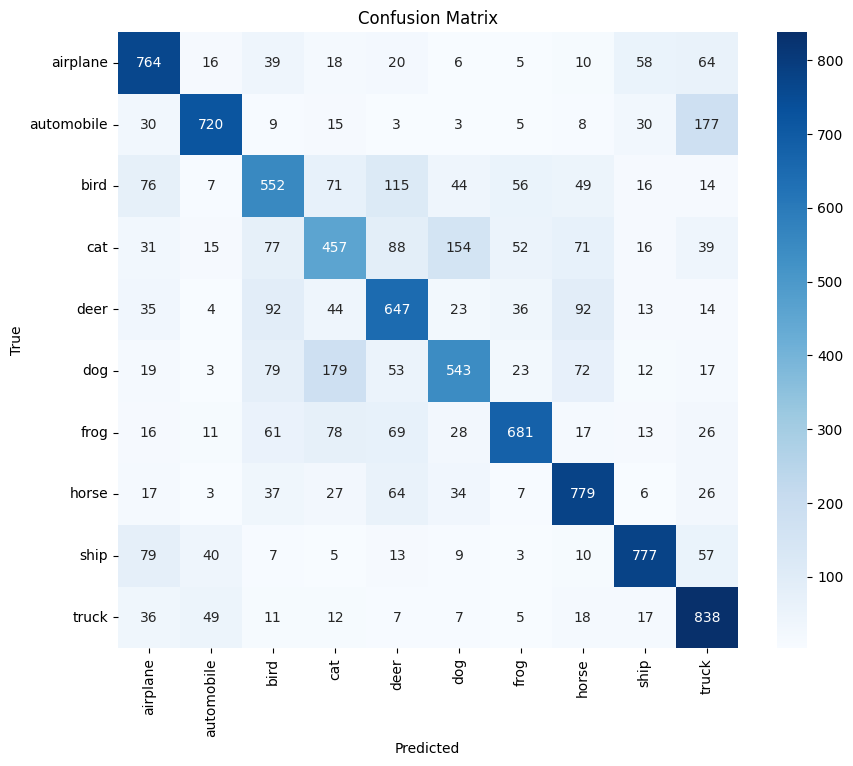

Confusion Matrix for 1x1+3x3


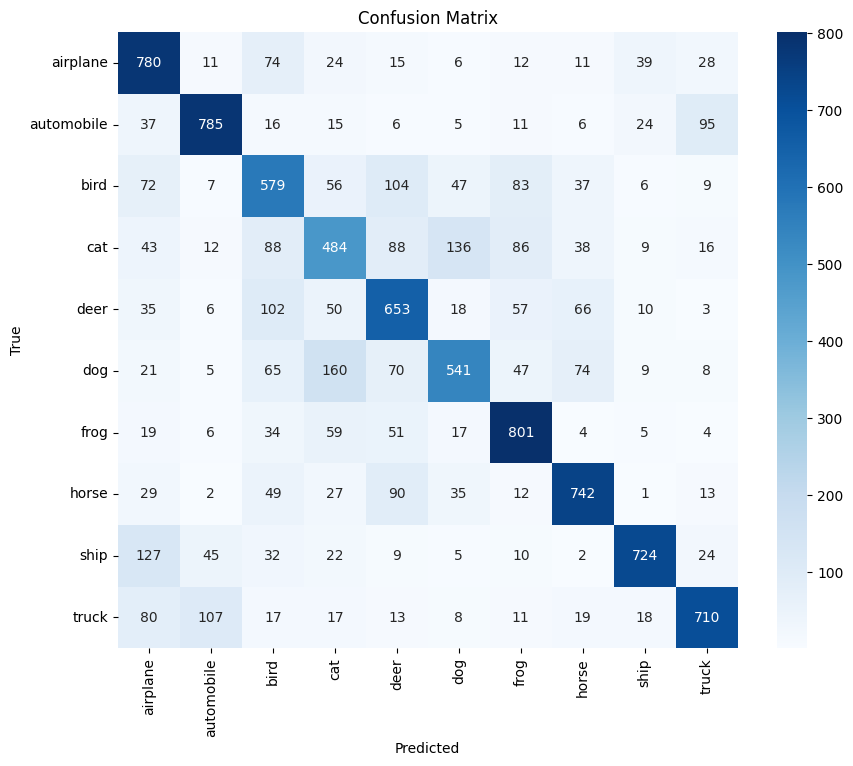

In [101]:
for d in trained_models:
    print(f"Confusion Matrix for {d['label']}")
    plot_confusion_matrix(d['model'], test_loader_cifar, class_names=class_names_cifar, device=device)

In [104]:
loss_kernels = []
acc_kernels = []
time_kernels = []
kernel_labels = []

for d in trained_models:
    loss_kernels.append(d["results"]["train_losses"])
    acc_kernels.append(d["results"]["test_accs"])
    time_kernels.append(d["time"])
    kernel_labels.append(d["label"])

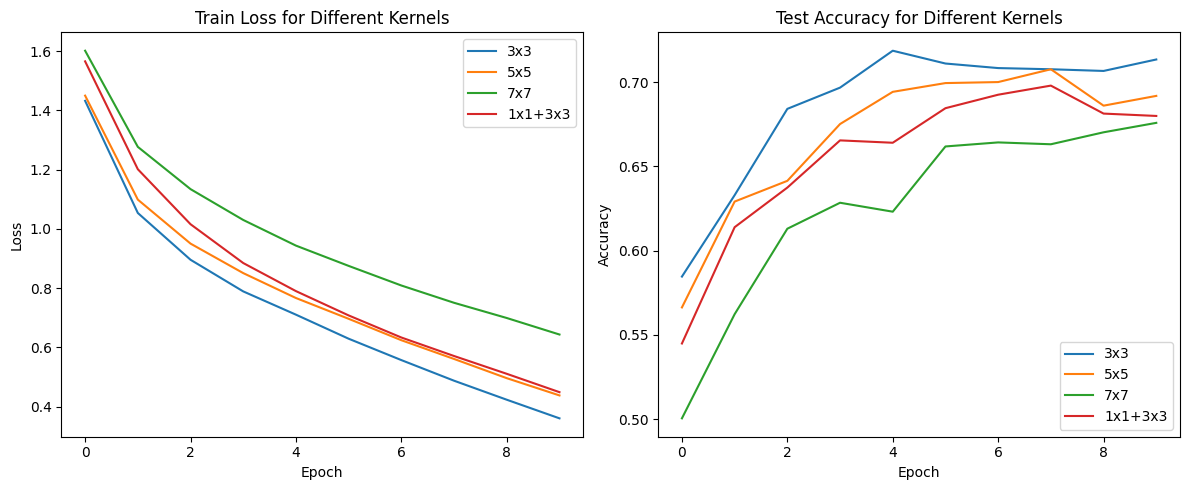

3x3: Training Time = 145.3s
5x5: Training Time = 109.4s
7x7: Training Time = 111.6s
1x1+3x3: Training Time = 123.5s


In [105]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for loss, label in zip(loss_kernels, kernel_labels):
    plt.plot(loss, label=label)
plt.title("Train Loss for Different Kernels")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
for acc, label in zip(acc_kernels, kernel_labels):
    plt.plot(acc, label=label)
plt.title("Test Accuracy for Different Kernels")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

for label, time_ in zip(kernel_labels, time_kernels):
    print(f"{label}: Training Time = {time_:.1f}s")


First Layer Activations for 3x3


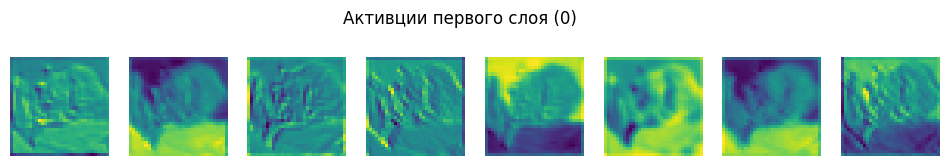

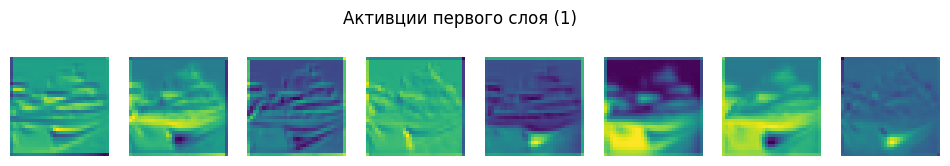


First Layer Activations for 5x5


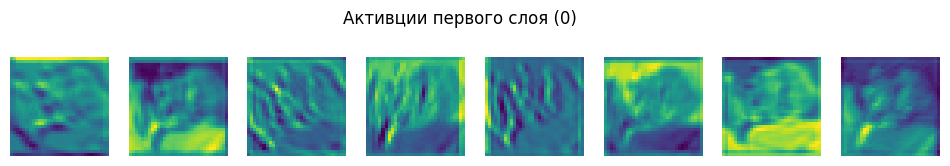

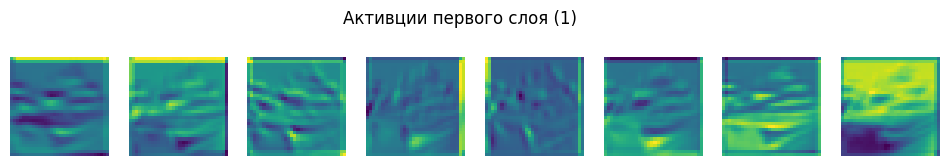


First Layer Activations for 7x7


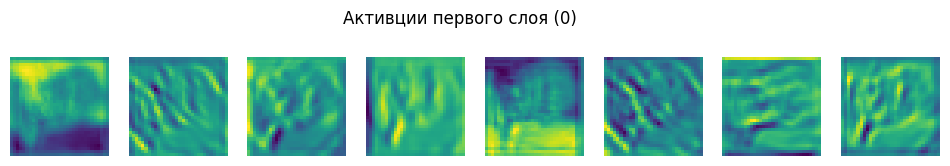

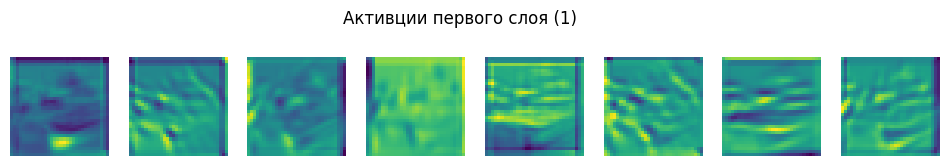


First Layer Activations for 1x1+3x3


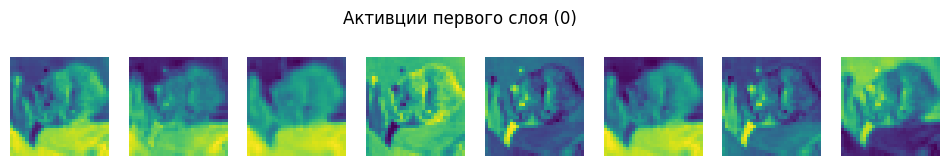

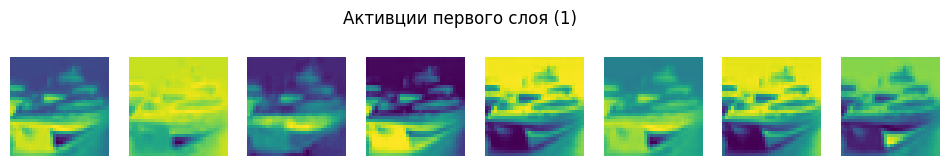

In [103]:
def visualize_first_layer_activations(model, test_loader, num_images=3):
    model.eval()
    device = next(model.parameters()).device
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images.to(device)

    first_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break
    if first_conv is None:
        raise ValueError("Нет Conv2d слоя.")

    with torch.no_grad():
        activations = first_conv(images[:num_images])
    activations = activations.cpu()

    for idx in range(num_images):
        plt.figure(figsize=(12,2))
        for i in range(min(8, activations.shape[1])):
            plt.subplot(1,8,i+1)
            plt.imshow(activations[idx,i].numpy(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"Активции первого слоя ({idx})")
        plt.show()

for d in trained_models:
    print(f"\nFirst Layer Activations for {d['label']}")
    visualize_first_layer_activations(d['model'], test_loader_cifar, num_images=2)

## 2.2 Влияние глубины CNN (15 баллов)

In [ ]:
# Исследуйте влияние глубины CNN:
# - Неглубокая CNN (2 conv слоя)
# - Средняя CNN (4 conv слоя)
# - Глубокая CNN (6+ conv слоев)
# - CNN с Residual связями
#
# Для каждого варианта:
# - Сравните точность и время обучения
# - Проанализируйте vanishing/exploding gradients
# - Исследуйте эффективность Residual связей
# - Визуализируйте feature maps

In [114]:
# - Неглубокая CNN (2 conv слоя)
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64*8*8,128)
        self.fc2 = nn.Linear(128,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# - Средняя CNN (4 conv слоя)
class MediumCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)
        self.pool = nn.MaxPool2d(2)
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.fc1 = nn.Linear(128*4*4,256)
        self.fc2 = nn.Linear(256,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# - Глубокая CNN (6+ conv слоев)
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)
        self.conv5 = nn.Conv2d(128,128,3,padding=1)
        self.conv6 = nn.Conv2d(128,128,3,padding=1)
        self.pool = nn.MaxPool2d(2)
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))
        self.fc1 = nn.Linear(128*4*4,256)
        self.fc2 = nn.Linear(256,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# - CNN с Residual связями
class DeepResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.res1 = ResidualBlock(32,32)
        self.res2 = ResidualBlock(32,64,stride=2)
        self.res3 = ResidualBlock(64,64)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(64*4*4,10)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        return self.fc(x)


Обучаем модели

In [115]:
models_configs = [
    ("Small CNN", SmallCNN()),
    ("Medium CNN", MediumCNN()),
    ("Deep CNN", DeepCNN()),
    ("Deep ResNet", DeepResNet())
]

trained_models = []

for label, model in models_configs:
    print(f"Training {label}")
    start = time.time()
    results = train_model_with_grads(model, train_loader_cifar, test_loader_cifar, epochs, lr)
    t = time.time()-start
    trained_models.append({
        "label": label,
        "model": model,
        "results": results,
        "time": t
    })

Training Small CNN


Epoch 1: Train loss=1.4904, Test Acc=0.5305


Epoch 2: Train loss=1.1253, Test Acc=0.6180


Epoch 3: Train loss=0.9727, Test Acc=0.6681


Epoch 4: Train loss=0.8726, Test Acc=0.6843


Epoch 5: Train loss=0.7927, Test Acc=0.6854


Epoch 6: Train loss=0.7251, Test Acc=0.6979


Epoch 7: Train loss=0.6550, Test Acc=0.7008


Epoch 8: Train loss=0.5945, Test Acc=0.6977


Epoch 9: Train loss=0.5439, Test Acc=0.6956


Epoch 10: Train loss=0.4844, Test Acc=0.7053
Training Medium CNN


Epoch 1: Train loss=1.6095, Test Acc=0.5095


Epoch 2: Train loss=1.2198, Test Acc=0.5821


Epoch 3: Train loss=1.0534, Test Acc=0.6365


Epoch 4: Train loss=0.9283, Test Acc=0.6673


Epoch 5: Train loss=0.8283, Test Acc=0.7008


Epoch 6: Train loss=0.7497, Test Acc=0.7139


Epoch 7: Train loss=0.6797, Test Acc=0.7112


Epoch 8: Train loss=0.6062, Test Acc=0.7241


Epoch 9: Train loss=0.5466, Test Acc=0.7046


Epoch 10: Train loss=0.4925, Test Acc=0.7431
Training Deep CNN


Epoch 1: Train loss=1.7435, Test Acc=0.4432


Epoch 2: Train loss=1.3164, Test Acc=0.5792


Epoch 3: Train loss=1.0918, Test Acc=0.6325


Epoch 4: Train loss=0.9511, Test Acc=0.6636


Epoch 5: Train loss=0.8363, Test Acc=0.6937


Epoch 6: Train loss=0.7520, Test Acc=0.7128


Epoch 7: Train loss=0.6840, Test Acc=0.7194


Epoch 8: Train loss=0.6234, Test Acc=0.7244


Epoch 9: Train loss=0.5721, Test Acc=0.7452


Epoch 10: Train loss=0.5152, Test Acc=0.7445
Training Deep ResNet


Epoch 1: Train loss=1.2081, Test Acc=0.6295


Epoch 2: Train loss=0.7922, Test Acc=0.7155


Epoch 3: Train loss=0.6574, Test Acc=0.7229


Epoch 4: Train loss=0.5667, Test Acc=0.7307


Epoch 5: Train loss=0.4980, Test Acc=0.7808


Epoch 6: Train loss=0.4409, Test Acc=0.7983


Epoch 7: Train loss=0.3991, Test Acc=0.8005


Epoch 8: Train loss=0.3534, Test Acc=0.7995


Epoch 9: Train loss=0.3191, Test Acc=0.8066


Epoch 10: Train loss=0.2835, Test Acc=0.8228


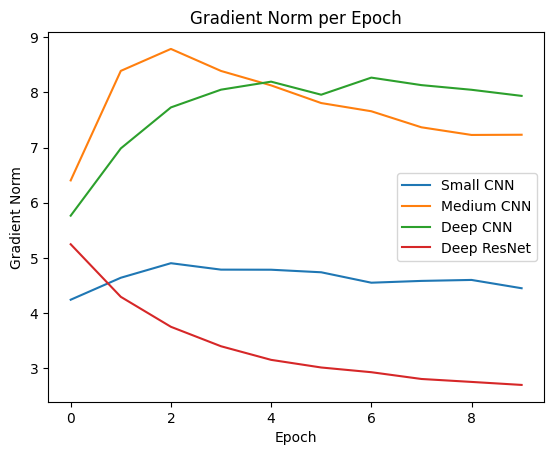

In [116]:
plt.figure()
for d in trained_models:
    plt.plot(d["results"]["grad_norms"], label=d["label"])
plt.title("Gradient Norm per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Gradient Norm")
plt.legend()
plt.show()


Feature maps for Small CNN


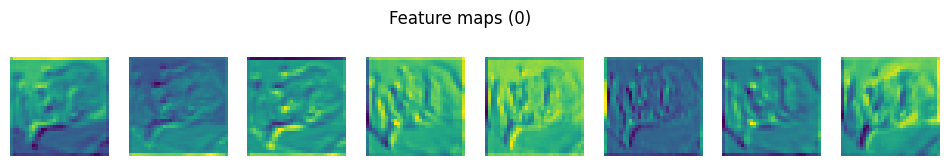

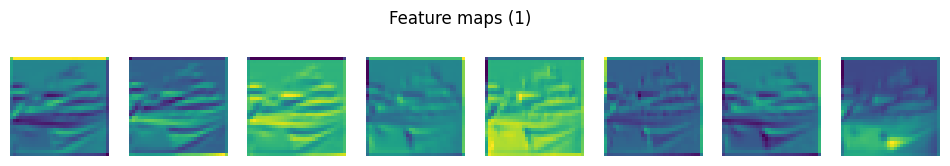


Feature maps for Medium CNN


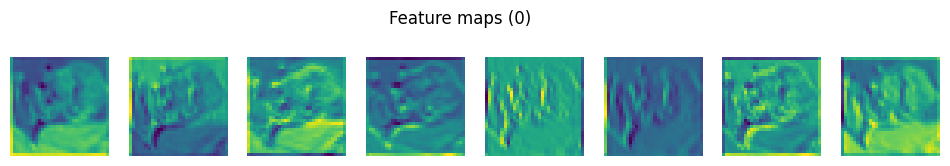

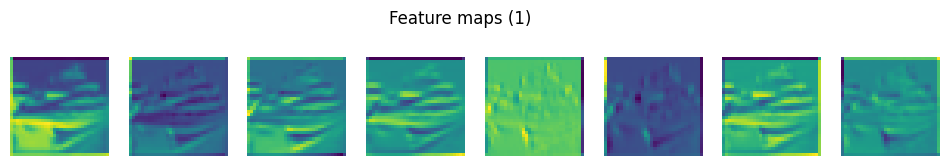


Feature maps for Deep CNN


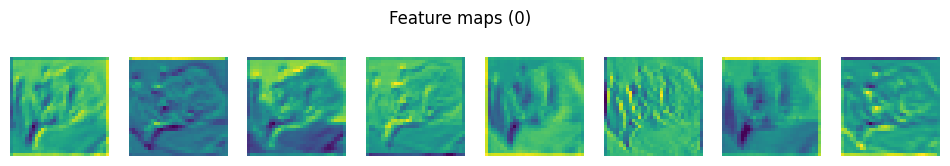

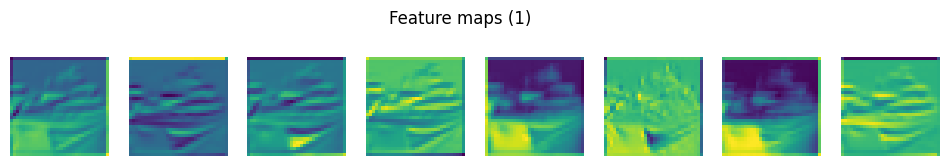


Feature maps for Deep ResNet


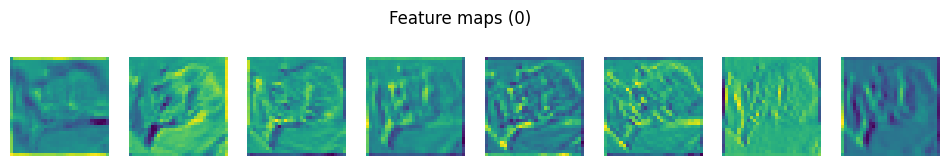

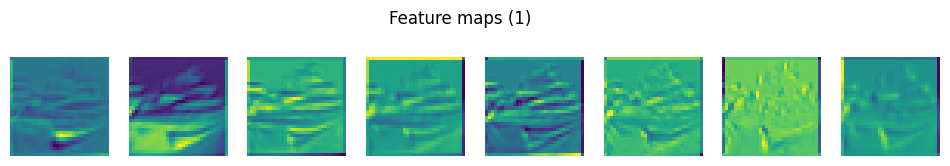

In [123]:
def visualize_feature_maps(model, test_loader, num_images=2):
    model.eval()
    device = next(model.parameters()).device
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images.to(device)

    first_conv = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv = module
            break
    if first_conv is None:
        raise ValueError("Нет Conv2d слоя")

    with torch.no_grad():
        activations = first_conv(images[:num_images])
    activations = activations.cpu()

    for idx in range(num_images):
        plt.figure(figsize=(12,2))
        for i in range(min(8, activations.shape[1])):
            plt.subplot(1,8,i+1)
            plt.imshow(activations[idx,i].numpy(), cmap='viridis')
            plt.axis('off')
        plt.suptitle(f"Feature maps ({idx})")
        plt.show()

for d in trained_models:
    print(f"\nFeature maps for {d['label']}")
    visualize_feature_maps(d['model'], test_loader_cifar, num_images=2)

Все способны выделить важные участки изображения

In [125]:
for d in trained_models:
    print(f"{d['label']}: Time = {d['time']:.1f}s, Final Test Accuracy = {d['results']['test_accs'][-1]:.4f}")

Small CNN: Time = 111.0s, Final Test Accuracy = 0.7053
Medium CNN: Time = 133.4s, Final Test Accuracy = 0.7431
Deep CNN: Time = 162.7s, Final Test Accuracy = 0.7445
Deep ResNet: Time = 192.9s, Final Test Accuracy = 0.8228


Лучше всех себя показала модель DeepResNet, с Accuracy 0.8228

# Задание 3: Кастомные слои и эксперименты (30 баллов)

## 3.1 Реализация кастомных слоев (15 баллов)

In [ ]:
# Реализуйте кастомные слои:
# - Кастомный сверточный слой с дополнительной логикой
# - Attention механизм для CNN
# - Кастомная функция активации
# - Кастомный pooling слой
#
# Для каждого слоя:
# - Реализуйте forward и backward проходы
# - Добавьте параметры если необходимо
# - Протестируйте на простых примерах
# - Сравните с стандартными аналогами

Cверточный слой с масштабированием выходного тензора по learnable параметру scale

In [131]:
# Cверточный слой с масштабированием выходного тензора по learnable параметру scale
class CustomConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        out = self.conv(x)
        out = out * self.scale
        return out
# Модель
class CustomConvCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = CustomConvLayer(3,32)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool2 = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(64*4*4,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)

Классическая Squeeze-and-Excitation block (Hu et al., 2018)

In [132]:
class SqueezeExcitation(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        batch, channels, _, _ = x.size()
        y = self.global_pool(x).view(batch, channels)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(batch, channels, 1, 1)
        return x * y

# Модель
class SE_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.se = SqueezeExcitation(32)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool2 = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(64*4*4,10)

    def forward(self,x):
        x = self.pool(F.relu(self.se(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)

Кастомная функция активации

In [133]:
class Swish(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

# Модель
class CustomActivationCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.swish = Swish(beta=1.0)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool2 = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(64*4*4,10)

    def forward(self,x):
        x = self.pool(self.swish(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)

pooling слой

In [151]:
class LP_Pooling(nn.Module):
    def __init__(self, p=2.0, kernel_size=2, stride=2):
        super().__init__()
        self.p = p
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        x_p = x.abs().pow(self.p)
        pooled = F.avg_pool2d(x_p, self.kernel_size, self.stride)
        result = pooled.pow(1.0 / self.p)
        return result

# Модель
class LpPoolingCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,32,3,padding=1)
        self.pool = LP_Pooling(p=2.0)
        self.conv2 = nn.Conv2d(32,64,3,padding=1)
        self.pool2 = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(64*4*4,10)

    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0),-1)
        return self.fc(x)

In [139]:
models_list = [
    ("SimpleCNN", SimpleCNN(input_channels=3).to(device)),
    ("CustomConvCNN", CustomConvCNN().to(device)),
    ("SE_CNN", SE_CNN().to(device)),
    ("CustomActivationCNN", CustomActivationCNN().to(device)),
    ("LpPoolingCNN", LpPoolingCNN().to(device))
]

trained_models = []

for label, model in models_list:
    print(f"Training {label}")
    start = time.time()
    results = train_model(model, train_loader_cifar, test_loader_cifar, epochs, lr, device)
    t = time.time()-start

    trained_models.append({
        "label": label,
        "model": model,
        "results": results,
        "time": t
    })

Training SimpleCNN


100%|██████████| 157/157 [00:01<00:00, 113.13it/s]


Epoch 1/10:
Train Loss: 1.9163, Train Acc: 0.3074
Test Loss: 1.6613, Test Acc: 0.4096
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 115.08it/s]


Epoch 2/10:
Train Loss: 1.6711, Train Acc: 0.3988
Test Loss: 1.5461, Test Acc: 0.4505
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 91.39it/s] 


Epoch 3/10:
Train Loss: 1.5914, Train Acc: 0.4254
Test Loss: 1.4950, Test Acc: 0.4662
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 101.89it/s]


Epoch 4/10:
Train Loss: 1.5397, Train Acc: 0.4410
Test Loss: 1.4348, Test Acc: 0.4894
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.36it/s]


Epoch 5/10:
Train Loss: 1.4983, Train Acc: 0.4583
Test Loss: 1.4117, Test Acc: 0.5010
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 115.10it/s]


Epoch 6/10:
Train Loss: 1.4642, Train Acc: 0.4712
Test Loss: 1.3663, Test Acc: 0.5141
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 115.11it/s]


Epoch 7/10:
Train Loss: 1.4391, Train Acc: 0.4781
Test Loss: 1.3564, Test Acc: 0.5192
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.75it/s]


Epoch 8/10:
Train Loss: 1.4120, Train Acc: 0.4906
Test Loss: 1.3179, Test Acc: 0.5368
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 114.67it/s]


Epoch 9/10:
Train Loss: 1.3886, Train Acc: 0.5021
Test Loss: 1.2982, Test Acc: 0.5380
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 84.74it/s]


Epoch 10/10:
Train Loss: 1.3755, Train Acc: 0.5049
Test Loss: 1.2877, Test Acc: 0.5428
--------------------------------------------------
Training CustomConvCNN


100%|██████████| 157/157 [00:01<00:00, 88.15it/s]


Epoch 1/10:
Train Loss: 1.6829, Train Acc: 0.3991
Test Loss: 1.4644, Test Acc: 0.4791
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.77it/s]


Epoch 2/10:
Train Loss: 1.3884, Train Acc: 0.5095
Test Loss: 1.3380, Test Acc: 0.5268
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.87it/s]


Epoch 3/10:
Train Loss: 1.2602, Train Acc: 0.5559
Test Loss: 1.2018, Test Acc: 0.5750
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.42it/s]


Epoch 4/10:
Train Loss: 1.1690, Train Acc: 0.5899
Test Loss: 1.1172, Test Acc: 0.6081
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.29it/s]


Epoch 5/10:
Train Loss: 1.0973, Train Acc: 0.6149
Test Loss: 1.0674, Test Acc: 0.6320
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 83.88it/s]


Epoch 6/10:
Train Loss: 1.0344, Train Acc: 0.6399
Test Loss: 1.0238, Test Acc: 0.6445
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 110.16it/s]


Epoch 7/10:
Train Loss: 0.9815, Train Acc: 0.6591
Test Loss: 1.0085, Test Acc: 0.6469
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 92.43it/s] 


Epoch 8/10:
Train Loss: 0.9487, Train Acc: 0.6694
Test Loss: 0.9917, Test Acc: 0.6463
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 91.68it/s]


Epoch 9/10:
Train Loss: 0.9081, Train Acc: 0.6876
Test Loss: 0.9207, Test Acc: 0.6796
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 109.87it/s]


Epoch 10/10:
Train Loss: 0.8804, Train Acc: 0.6958
Test Loss: 0.9212, Test Acc: 0.6802
--------------------------------------------------
Training SE_CNN


100%|██████████| 157/157 [00:01<00:00, 110.55it/s]


Epoch 1/10:
Train Loss: 1.7122, Train Acc: 0.3913
Test Loss: 1.4743, Test Acc: 0.4746
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.46it/s]


Epoch 2/10:
Train Loss: 1.4155, Train Acc: 0.4978
Test Loss: 1.3668, Test Acc: 0.5196
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 111.34it/s]


Epoch 3/10:
Train Loss: 1.3015, Train Acc: 0.5440
Test Loss: 1.2807, Test Acc: 0.5530
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.61it/s]


Epoch 4/10:
Train Loss: 1.2317, Train Acc: 0.5686
Test Loss: 1.2065, Test Acc: 0.5659
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.65it/s]


Epoch 5/10:
Train Loss: 1.1661, Train Acc: 0.5900
Test Loss: 1.1422, Test Acc: 0.6014
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.34it/s]


Epoch 6/10:
Train Loss: 1.1064, Train Acc: 0.6143
Test Loss: 1.0779, Test Acc: 0.6258
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 86.20it/s] 


Epoch 7/10:
Train Loss: 1.0559, Train Acc: 0.6332
Test Loss: 1.0353, Test Acc: 0.6411
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 93.69it/s]


Epoch 8/10:
Train Loss: 1.0160, Train Acc: 0.6472
Test Loss: 1.0290, Test Acc: 0.6430
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.09it/s]


Epoch 9/10:
Train Loss: 0.9820, Train Acc: 0.6596
Test Loss: 0.9807, Test Acc: 0.6591
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.99it/s]


Epoch 10/10:
Train Loss: 0.9540, Train Acc: 0.6695
Test Loss: 0.9649, Test Acc: 0.6667
--------------------------------------------------
Training CustomActivationCNN


100%|██████████| 157/157 [00:01<00:00, 112.29it/s]


Epoch 1/10:
Train Loss: 1.7097, Train Acc: 0.3933
Test Loss: 1.4846, Test Acc: 0.4716
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 73.53it/s] 


Epoch 2/10:
Train Loss: 1.4184, Train Acc: 0.4990
Test Loss: 1.3657, Test Acc: 0.5158
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.59it/s]


Epoch 3/10:
Train Loss: 1.3113, Train Acc: 0.5373
Test Loss: 1.2751, Test Acc: 0.5566
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 111.64it/s]


Epoch 4/10:
Train Loss: 1.2465, Train Acc: 0.5616
Test Loss: 1.2303, Test Acc: 0.5661
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.33it/s]


Epoch 5/10:
Train Loss: 1.1868, Train Acc: 0.5845
Test Loss: 1.1908, Test Acc: 0.5770
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 113.23it/s]


Epoch 6/10:
Train Loss: 1.1463, Train Acc: 0.5979
Test Loss: 1.1246, Test Acc: 0.6021
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 110.57it/s]


Epoch 7/10:
Train Loss: 1.1019, Train Acc: 0.6162
Test Loss: 1.1044, Test Acc: 0.6102
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.42it/s]


Epoch 8/10:
Train Loss: 1.0615, Train Acc: 0.6289
Test Loss: 1.0510, Test Acc: 0.6320
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 108.77it/s]


Epoch 9/10:
Train Loss: 1.0244, Train Acc: 0.6436
Test Loss: 1.0343, Test Acc: 0.6367
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.05it/s]


Epoch 10/10:
Train Loss: 0.9930, Train Acc: 0.6557
Test Loss: 0.9826, Test Acc: 0.6588
--------------------------------------------------
Training LpPoolingCNN


100%|██████████| 157/157 [00:01<00:00, 107.64it/s]


Epoch 1/10:
Train Loss: nan, Train Acc: 0.1001
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 89.28it/s] 


Epoch 2/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 82.63it/s]


Epoch 3/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.38it/s]


Epoch 4/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 89.25it/s]


Epoch 5/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 103.16it/s]


Epoch 6/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.74it/s]


Epoch 7/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 112.85it/s]


Epoch 8/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 111.25it/s]


Epoch 9/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 111.55it/s]

Epoch 10/10:
Train Loss: nan, Train Acc: 0.1000
Test Loss: nan, Test Acc: 0.1000
--------------------------------------------------


In [154]:
print(f"Training {label}")
model = LpPoolingCNN().to(device)
start = time.time()
results = train_model(model, train_loader_cifar, test_loader_cifar, epochs, lr, device)
t = time.time()-start

trained_models.append({
    "label": label,
    "model": model,
    "results": results,
    "time": t
})

Training LpPoolingCNN


100%|██████████| 157/157 [00:01<00:00, 109.95it/s]


Epoch 1/10:
Train Loss: 1.7323, Train Acc: 0.3883
Test Loss: 1.5507, Test Acc: 0.4432
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 110.18it/s]


Epoch 2/10:
Train Loss: 1.4410, Train Acc: 0.4897
Test Loss: 1.3545, Test Acc: 0.5229
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 111.20it/s]


Epoch 3/10:
Train Loss: 1.3353, Train Acc: 0.5286
Test Loss: 1.3036, Test Acc: 0.5346
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 109.63it/s]


Epoch 4/10:
Train Loss: 1.2702, Train Acc: 0.5536
Test Loss: 1.2318, Test Acc: 0.5644
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 109.57it/s]


Epoch 5/10:
Train Loss: 1.2125, Train Acc: 0.5748
Test Loss: 1.2168, Test Acc: 0.5677
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 110.27it/s]


Epoch 6/10:
Train Loss: 1.1644, Train Acc: 0.5916
Test Loss: 1.1381, Test Acc: 0.5970
--------------------------------------------------


100%|██████████| 157/157 [00:03<00:00, 49.82it/s]


Epoch 7/10:
Train Loss: 1.1210, Train Acc: 0.6074
Test Loss: 1.0964, Test Acc: 0.6173
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 89.83it/s] 


Epoch 8/10:
Train Loss: 1.0804, Train Acc: 0.6237
Test Loss: 1.0613, Test Acc: 0.6277
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 78.44it/s]


Epoch 9/10:
Train Loss: 1.0467, Train Acc: 0.6342
Test Loss: 1.0685, Test Acc: 0.6276
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 100.96it/s]


Epoch 10/10:
Train Loss: 1.0180, Train Acc: 0.6455
Test Loss: 1.0362, Test Acc: 0.6372
--------------------------------------------------


In [156]:
trained_models.pop(4)

{'label': 'LpPoolingCNN',
 'model': LpPoolingCNN(
   (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool): LP_Pooling()
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool2): AdaptiveAvgPool2d(output_size=(4, 4))
   (fc): Linear(in_features=1024, out_features=10, bias=True)
 ),
 'results': {'train_losses': [nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan],
  'train_accs': [0.10006, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
  'test_losses': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
  'test_accs': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]},
 'time': 115.6268208026886}

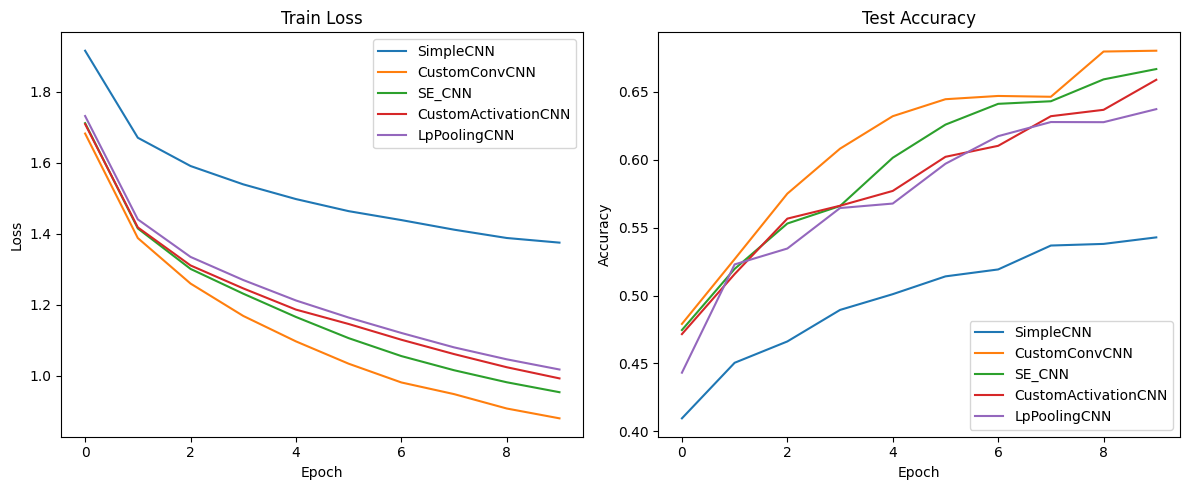

In [158]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for d in trained_models:
    plt.plot(d["results"]["train_losses"], label=d["label"])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
for d in trained_models:
    plt.plot(d["results"]["test_accs"], label=d["label"])
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [157]:
for d in trained_models:
    print(f"{d['label']}: Time={d['time']:.1f}s, Final Test Accuracy={d['results']['test_accs'][-1]:.4f}")

SimpleCNN: Time=105.0s, Final Test Accuracy=0.5428
CustomConvCNN: Time=106.0s, Final Test Accuracy=0.6802
SE_CNN: Time=107.7s, Final Test Accuracy=0.6667
CustomActivationCNN: Time=115.3s, Final Test Accuracy=0.6588
LpPoolingCNN: Time=114.1s, Final Test Accuracy=0.6372


Дополнительные слои дали прирост, лучше всего показал сверточный слой

## 3.2 Эксперименты с Residual блоками (15 баллов)

In [ ]:
# Исследуйте различные варианты Residual блоков:
# - Базовый Residual блок
# - Bottleneck Residual блок
# - Wide Residual блок
#
# Для каждого варианта:
# - Реализуйте блок с нуля
# - Сравните производительность
# - Проанализируйте количество параметров
# - Исследуйте стабильность обучения

In [159]:
class BasicResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


class BottleneckResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, expansion=4):
        super().__init__()
        mid_channels = out_channels // expansion
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, 3, stride, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv3 = nn.Conv2d(mid_channels, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return F.relu(out)


class WideResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, widen_factor=4):
        super().__init__()
        width = out_channels * widen_factor
        self.conv1 = nn.Conv2d(in_channels, width, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(width)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != width:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, width, 1, stride, bias=False),
                nn.BatchNorm2d(width)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)



class ResNetBottleneck(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, 3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.layer1 = BottleneckResidualBlock(64, 256, stride=2)
        self.layer2 = BottleneckResidualBlock(256, 256)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(256*4*4, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        return self.fc(x)

In [160]:
class ResNetBasic(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, 3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.layer1 = BasicResidualBlock(32, 64, stride=2)
        self.layer2 = BasicResidualBlock(64, 64)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(64*4*4, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        return self.fc(x)


class ResNetBottleneck(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 64, 3, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.layer1 = BottleneckResidualBlock(64, 256, stride=2)
        self.layer2 = BottleneckResidualBlock(256, 256)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(256*4*4, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        return self.fc(x)


class ResNetWide(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, 3, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.layer1 = WideResidualBlock(16, 32, stride=2, widen_factor=4)
        self.layer2 = WideResidualBlock(128, 32, widen_factor=4)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Linear(128*4*4, 10)

    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        return self.fc(x)

In [163]:
models_list = [
    ("BasicResNet", ResNetBasic().to(device)),
    ("BottleneckResNet", ResNetBottleneck().to(device)),
    ("WideResNet", ResNetWide().to(device))
]

for label, model in models_list:
    print(f"Training {label}")
    start = time.time()
    results = train_model(model, train_loader_cifar, test_loader_cifar, epochs, lr, device)
    t = time.time()-start

    trained_models.append({
        "label": label,
        "model": model,
        "results": results,
        "time": t
    })

Training BasicResNet


100%|██████████| 157/157 [00:01<00:00, 83.47it/s]


Epoch 1/10:
Train Loss: 1.1963, Train Acc: 0.5701
Test Loss: 1.0365, Test Acc: 0.6324
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 66.52it/s]


Epoch 2/10:
Train Loss: 0.8168, Train Acc: 0.7136
Test Loss: 0.8728, Test Acc: 0.6957
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 59.61it/s]


Epoch 3/10:
Train Loss: 0.6877, Train Acc: 0.7600
Test Loss: 0.8379, Test Acc: 0.7077
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 80.69it/s]


Epoch 4/10:
Train Loss: 0.5997, Train Acc: 0.7900
Test Loss: 0.7137, Test Acc: 0.7461
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 98.76it/s] 


Epoch 5/10:
Train Loss: 0.5348, Train Acc: 0.8149
Test Loss: 0.7974, Test Acc: 0.7327
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 102.33it/s]


Epoch 6/10:
Train Loss: 0.4785, Train Acc: 0.8340
Test Loss: 0.5976, Test Acc: 0.7962
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 102.32it/s]


Epoch 7/10:
Train Loss: 0.4354, Train Acc: 0.8494
Test Loss: 0.6038, Test Acc: 0.7926
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 102.62it/s]


Epoch 8/10:
Train Loss: 0.3913, Train Acc: 0.8637
Test Loss: 0.5670, Test Acc: 0.8063
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 103.13it/s]


Epoch 9/10:
Train Loss: 0.3556, Train Acc: 0.8763
Test Loss: 0.6930, Test Acc: 0.7724
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 103.49it/s]


Epoch 10/10:
Train Loss: 0.3158, Train Acc: 0.8902
Test Loss: 0.6548, Test Acc: 0.7864
--------------------------------------------------
Training BottleneckResNet


100%|██████████| 157/157 [00:01<00:00, 85.64it/s]


Epoch 1/10:
Train Loss: 1.2278, Train Acc: 0.5664
Test Loss: 1.2791, Test Acc: 0.5908
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 84.38it/s]


Epoch 2/10:
Train Loss: 0.8277, Train Acc: 0.7128
Test Loss: 0.8310, Test Acc: 0.7140
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 83.90it/s]


Epoch 3/10:
Train Loss: 0.7016, Train Acc: 0.7567
Test Loss: 0.7964, Test Acc: 0.7234
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 85.09it/s]


Epoch 4/10:
Train Loss: 0.6104, Train Acc: 0.7852
Test Loss: 0.9429, Test Acc: 0.6839
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 81.32it/s]


Epoch 5/10:
Train Loss: 0.5452, Train Acc: 0.8103
Test Loss: 0.6304, Test Acc: 0.7819
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 84.51it/s]


Epoch 6/10:
Train Loss: 0.4943, Train Acc: 0.8291
Test Loss: 0.7981, Test Acc: 0.7386
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 76.17it/s]


Epoch 7/10:
Train Loss: 0.4472, Train Acc: 0.8443
Test Loss: 0.7295, Test Acc: 0.7631
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 84.65it/s]


Epoch 8/10:
Train Loss: 0.4036, Train Acc: 0.8600
Test Loss: 0.6959, Test Acc: 0.7679
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 72.55it/s]


Epoch 9/10:
Train Loss: 0.3667, Train Acc: 0.8724
Test Loss: 0.6714, Test Acc: 0.7812
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 85.82it/s]


Epoch 10/10:
Train Loss: 0.3291, Train Acc: 0.8856
Test Loss: 0.6053, Test Acc: 0.8011
--------------------------------------------------
Training WideResNet


100%|██████████| 157/157 [00:02<00:00, 64.48it/s]


Epoch 1/10:
Train Loss: 1.1679, Train Acc: 0.5844
Test Loss: 0.9205, Test Acc: 0.6810
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 91.16it/s]


Epoch 2/10:
Train Loss: 0.7797, Train Acc: 0.7277
Test Loss: 0.7631, Test Acc: 0.7267
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 92.28it/s]


Epoch 3/10:
Train Loss: 0.6246, Train Acc: 0.7830
Test Loss: 0.6675, Test Acc: 0.7630
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 92.58it/s]


Epoch 4/10:
Train Loss: 0.5315, Train Acc: 0.8153
Test Loss: 0.6557, Test Acc: 0.7712
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 77.34it/s]


Epoch 5/10:
Train Loss: 0.4445, Train Acc: 0.8458
Test Loss: 0.6159, Test Acc: 0.7914
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 92.63it/s]


Epoch 6/10:
Train Loss: 0.3773, Train Acc: 0.8683
Test Loss: 0.6601, Test Acc: 0.7807
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 90.68it/s]


Epoch 7/10:
Train Loss: 0.3165, Train Acc: 0.8894
Test Loss: 0.5997, Test Acc: 0.8021
--------------------------------------------------


100%|██████████| 157/157 [00:02<00:00, 67.83it/s]


Epoch 8/10:
Train Loss: 0.2563, Train Acc: 0.9113
Test Loss: 0.5897, Test Acc: 0.8124
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 91.88it/s]


Epoch 9/10:
Train Loss: 0.2052, Train Acc: 0.9288
Test Loss: 0.6312, Test Acc: 0.8033
--------------------------------------------------


100%|██████████| 157/157 [00:01<00:00, 90.64it/s]

Epoch 10/10:
Train Loss: 0.1675, Train Acc: 0.9421
Test Loss: 0.6200, Test Acc: 0.8147
--------------------------------------------------


In [164]:
for d in trained_models:
    num_params = sum(p.numel() for p in d["model"].parameters())
    print(f"{d['label']}: Params={num_params}")

SimpleCNN: Params=545098
CustomConvCNN: Params=29643
SE_CNN: Params=29804
CustomActivationCNN: Params=29643
LpPoolingCNN: Params=29642
BasicResNet: Params=142922
BottleneckResNet: Params=188298
WideResNet: Params=485098


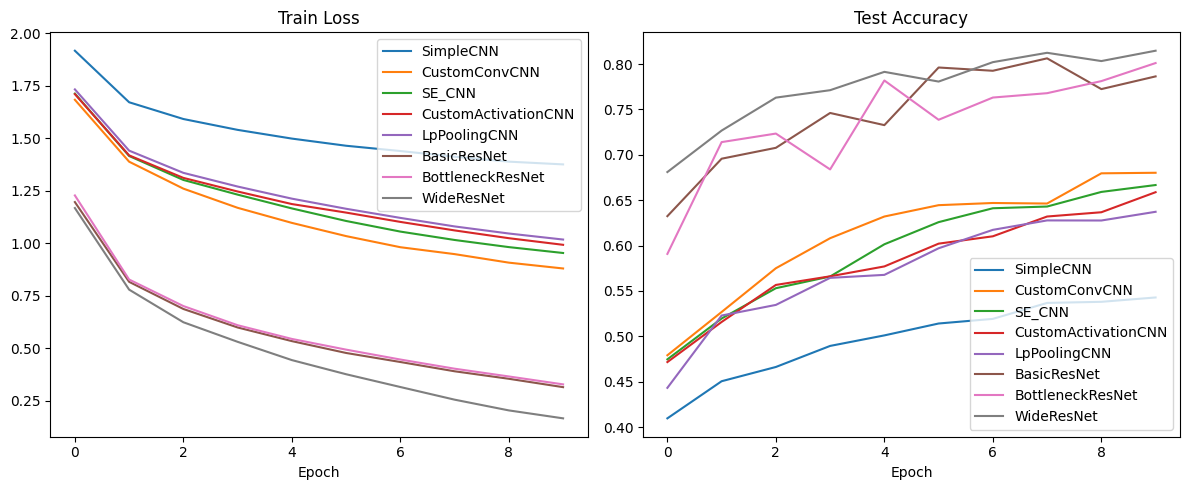

In [165]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for d in trained_models:
    plt.plot(d["results"]["train_losses"], label=d["label"])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1,2,2)
for d in trained_models:
    plt.plot(d["results"]["test_accs"], label=d["label"])
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.tight_layout()
plt.show()


In [166]:
for d in trained_models:
    print(f"{d['label']}: Time={d['time']:.1f}s, Final Test Acc={d['results']['test_accs'][-1]:.4f}")

SimpleCNN: Time=105.0s, Final Test Acc=0.5428
CustomConvCNN: Time=106.0s, Final Test Acc=0.6802
SE_CNN: Time=107.7s, Final Test Acc=0.6667
CustomActivationCNN: Time=115.3s, Final Test Acc=0.6588
LpPoolingCNN: Time=114.1s, Final Test Acc=0.6372
BasicResNet: Time=139.9s, Final Test Acc=0.7864
BottleneckResNet: Time=180.7s, Final Test Acc=0.8011
WideResNet: Time=158.9s, Final Test Acc=0.8147


Хорошие показатели accuracy у этих моделей, значительно выше чем у других.